In [1]:
import torch
from random import randint
from utilities import chordUtil
from utilities import dataImport
from utilities.chordUtil import *
from utilities.dataImport import *
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random
import sys
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
print("use_cuda")
print(use_cuda)
#use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")

use_cuda
True


In [4]:
# Init
lenSeq = 16
#lenSeq = 48
alpha = 'a0'
rootname = "inputs/jazz_xlab/"
filenames = os.listdir(rootname)
#filenames.remove(".DS_Store")
dictChord, listChord = chordUtil.getDictChord(eval(alpha))
print(len(dictChord))
print(dictChord)

25
{'F:min': 0, 'N': 1, 'C:maj': 2, 'C#:min': 3, 'G:min': 4, 'A#:min': 5, 'D:maj': 6, 'A:maj': 7, 'F:maj': 8, 'D:min': 9, 'G#:min': 10, 'E:maj': 11, 'G#:maj': 12, 'C#:maj': 13, 'F#:min': 14, 'E:min': 15, 'C:min': 16, 'A:min': 17, 'A#:maj': 18, 'D#:maj': 19, 'B:maj': 20, 'F#:maj': 21, 'D#:min': 22, 'G:maj': 23, 'B:min': 24}


In [5]:
# Create datasets
files_train ,files_test = train_test_split(filenames,test_size=0.7)
dataset_train = dataImport.ChordSeqDataset(files_train, rootname, alpha, dictChord, lenSeq)
dataset_test = dataImport.ChordSeqDataset(files_test, rootname, alpha, dictChord, lenSeq)


In [6]:
# Create generators
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(dataset_train, **params)
testing_generator = data.DataLoader(dataset_test, **params)


In [7]:
class MYLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MYLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        #self.lstm2 = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.last_fully_connected = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_batch):
        output, (hidden, cell_state) = self.lstm1(input_batch)
        #output, (hidden, cell_state) = self.lstm2(output,(hidden, cell_state))
        #print(output.size(), hidden.size(), cell_state.size())
        output = output[:,-1,:]
        #hidden = hidden[-1,:,:]
        #cell_state = cell_state[-1,:,:]
        #output = torch.cat((output,hidden,cell_state),1)
        output = self.last_fully_connected(output)
        output = self.softmax(output)

        return output





In [8]:
def train(local_batch, local_labels):

    optimizer.zero_grad()
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    # if tensor of shape 1 in loss function (ex : CrossEntropy)
    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    
    
    
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)    
    
    #output, (hidden, cell_state) = lstm_nn(local_batch)
    #output = output[:,-1,:]
    
    output = lstm_nn(local_batch)
    #print(output.size())
    
    for i in range(len(local_batch)):
        #print(output[i].size(), local_labels[i].size())
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    
    
    
    loss = criterion(output, local_labels_argmax)
    #loss = criterion(output, local_labels)

    #print(output.size(),local_labels.size())
    
    loss.backward()
    optimizer.step()


    return output, loss.item() / len(local_batch), correct_guess, wrong_guess

In [9]:
def test(local_batch, local_labels):
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    # if tensor of shape 1 in loss function (ex : CrossEntropy)
    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    
    
    
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    
    #output, (hidden, cell_state) = lstm_nn(local_batch)
    #output = output[:,-1,:]
    
    output = lstm_nn(local_batch)

    
    for i in range(len(local_batch)):
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    loss = criterion(output, local_labels_argmax)
    #loss = criterion(output, local_labels)

    return output, loss.item() / len(local_batch), correct_guess, wrong_guess
    

In [59]:
#Init new model

#lstm_nn = nn.LSTM(len(dictChord), len(dictChord), num_layers = lenSeq*5, batch_first = True, dropout = 0.1).to(device)
lstm_nn = MYLSTM(input_size = len(dictChord), hidden_size = 256, num_layers = 2).to(device)


In [10]:
# Or Load previous model
lstm_nn = torch.load("models/lstm_2layers_256blocks.pt")

In [11]:
save = True
save_path = "models/lstm_2layers_256blocks.pt"

all_losses = []
test_losses = []
total_loss = 0 # Reset every plot_every iters
test_loss = 0

correct_guess_train, wrong_guess_train, correct_guess_test, wrong_guess_test = 0, 0, 0, 0
accuracy_test = []
accuracy_train = []

update_plot = False


start = time.time()

optimizer = torch.optim.Adam(lstm_nn.parameters(), lr = 1e-3)
#print(lstm_nn.parameters())
#optimizer = torch.optim.SGD(lstm_nn.parameters(), lr = 5e2, momentum=0.9)


#criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()


print_every = 2
plot_every = 2
max_epochs = 20


# Begin training

for epoch in range(1, max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        output, loss, correct_guess, wrong_guess = train(local_batch, local_labels)
        #print(loss)
        total_loss += loss
        correct_guess_train += correct_guess
        wrong_guess_train += wrong_guess

    if epoch % print_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        print('%s (%d %d%%) train, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        all_losses.append(total_loss / (plot_every ))
        accuracy_train.append(accuracy)
        total_loss = 0
        correct_guess_train, wrong_guess_train = 0, 0

        

    # Testing
    for local_batch, local_labels in testing_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output, loss, correct_guess, wrong_guess  = test(local_batch, local_labels)
        test_loss +=loss
        
        correct_guess_test += correct_guess
        wrong_guess_test += wrong_guess
        

    if epoch % print_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        print('%s (%d %d%%) test, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        test_losses.append(test_loss / (plot_every ))
        accuracy_test.append(accuracy)
        test_loss = 0
        correct_guess_test, wrong_guess_test = 0, 0
        
        
#experimental feature : plot in realtime
    if update_plot and plot_every ==1:
        if epoch == 1:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            print(range(epoch), accuracy_test)
            li, = ax.plot(epoch, accuracy_test)
            
            ax.relim() 
            ax.autoscale_view(True,True,True)
            fig.canvas.draw()
            plt.show(block=False)
        time.sleep(0.01)
        li.set_data(list(range(epoch)),accuracy_test)
        time.sleep(0.01)
        fig.canvas.draw()
        

if save:
    torch.save(lstm_nn, save_path)
    


/home/valentinbilot/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  # Remove the CWD from sys.path while we load stuff.


0m 1s (2 10%) train, loss : 0.0409, accuracy : 69.5193%
0m 2s (2 10%) test, loss : 0.1423, accuracy : 70.8731%
0m 3s (4 20%) train, loss : 0.0497, accuracy : 70.6917%
0m 4s (4 20%) test, loss : 0.0689, accuracy : 71.3246%
0m 5s (6 30%) train, loss : 0.0476, accuracy : 72.9191%
0m 6s (6 30%) test, loss : 0.2244, accuracy : 71.8013%
0m 8s (8 40%) train, loss : 0.0547, accuracy : 71.3951%
0m 8s (8 40%) test, loss : 0.1182, accuracy : 70.7476%
0m 10s (10 50%) train, loss : 0.0482, accuracy : 71.6295%
0m 11s (10 50%) test, loss : 0.0959, accuracy : 71.3497%
0m 12s (12 60%) train, loss : 0.0372, accuracy : 71.2192%
0m 13s (12 60%) test, loss : 0.1609, accuracy : 71.8264%
0m 15s (14 70%) train, loss : 0.1058, accuracy : 70.4572%
0m 15s (14 70%) test, loss : 0.0702, accuracy : 72.3532%
0m 17s (16 80%) train, loss : 0.0472, accuracy : 72.5674%
0m 18s (16 80%) test, loss : 0.0681, accuracy : 72.5289%
0m 19s (18 90%) train, loss : 0.0605, accuracy : 74.3845%
0m 20s (18 90%) test, loss : 0.0690, a

/home/valentinbilot/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type MYLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loss :


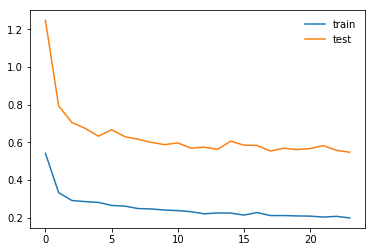

Accuracy :


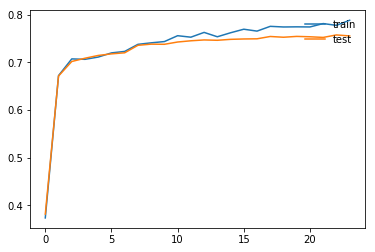

In [52]:
print("Loss :")
plt.figure()
plt.plot(all_losses, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(test_losses, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

print("Accuracy :")
plt.figure()
plt.plot(accuracy_train, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(accuracy_test, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

In [56]:
test_sequence = ["C:maj","F:maj","C:maj","C:maj",
                 "F:maj","F:maj","C:maj","C:maj",
                 "G:maj","F:maj","C:maj","G:maj",
                 "C:maj","C:maj","F:maj","C:maj"]

#test_sequence = ["C:maj","C:maj","C:maj","C:maj","F:maj","F:maj","F:maj","F:maj",
#                "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
#                "F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj",
#                "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
#                "G:maj","G:maj","G:maj","G:maj","F:maj","F:maj","F:maj","F:maj",
#                "C:maj","C:maj","C:maj","C:maj","G:maj","G:maj","G:maj","G:maj"]

test_sequence = test_sequence[0:lenSeq]
test_sequence_tensor = torch.zeros(1, len(test_sequence), len(dictChord)).to(device)
last_chords_output = torch.zeros(1, lenSeq, len(dictChord)).to(device)
for t in range(len(test_sequence)):
    test_sequence_tensor[0, t, dictChord[test_sequence[t]]] = 1
    last_chords_output[0, t, dictChord[test_sequence[t]]] = 1



In [57]:
generation_lenght = 120

generated_sequence = [0 for i in range(generation_lenght)]
generated_sequence[0:lenSeq] = test_sequence

lstm_nn.train(mode=False)

for t in range(generation_lenght-lenSeq):
    if t == 0:
        output = lstm_nn(test_sequence_tensor)
        #generated_sequence[t+lenSeq] = listChord[torch.argmax(output[0,-1]).item()]
        generated_sequence[t+lenSeq] = listChord[torch.argmax(output).item()]
    else : 
        #last_chords_output = torch.zeros(1, lenSeq, len(dictChord)).to(device)
        #for i in range(lenSeq):
            #last_chords_output[0, i, torch.argmax(output[0][-1]).item()] = 1
        #last_chords_output = torch.tensor([[torch.argmax(output[0][i]).item() for i in range(lenSeq)]])
        #print(output.size())
        output = lstm_nn(last_chords_output)
        last_chords_output[0,0:lenSeq-1] = last_chords_output[0,1:lenSeq]
        last_chords_output[0,lenSeq-1] = output
        last_chords_output.to(device)

        
        #output, (hidden, cell_state) = lstm_nn(last_chords_output, (hidden, cell_state))
        #generated_sequence[t+lenSeq] = listChord[torch.argmax(output[0][-1]).item()]
        
        output = lstm_nn(last_chords_output)
        generated_sequence[t+lenSeq] = listChord[torch.argmax(output).item()]

        
for i in range(generation_lenght):
    if i%4 == 0:
        print(generated_sequence[i:i+4])
    if i == lenSeq-1 :
        print("generated :")

['C:maj', 'F:maj', 'C:maj', 'C:maj']
['F:maj', 'F:maj', 'C:maj', 'C:maj']
['G:maj', 'F:maj', 'C:maj', 'G:maj']
['C:maj', 'C:maj', 'F:maj', 'C:maj']
generated :
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj'